In [58]:
def tokenize(s):
    return s.lower().split()

documents = [ # a.k.a text corpus
    "Human machine interface for lab abc computer applications",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering",
    "Graph minors A survey",
]

## Resources
[amount of training data](https://stackoverflow.com/questions/48059145/how-much-data-is-actually-required-to-train-a-doc2vec-model)

# [Core Concepts](https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html)
### preprocessed corpus: *filtering by stopwords and token frequencies*
- this is a bit simplistic

also see [`simple_preprocess()`](https://radimrehurek.com/gensim/utils.html#gensim.utils.simple_preprocess)

In [59]:
stoplist = set('for a of the and to in'.split(' '))
# remove stopwords
texts = [[word for word in tokenize(document) if word not in stoplist] 
             for document in documents]

from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
        
clean_corpus = [[token for token in text if frequency[token] > 1] for text in texts]
clean_corpus

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

### gensim dictionary
[Construct word<->id mappings](https://radimrehurek.com/gensim/corpora/dictionary.html)

In [60]:
from gensim import corpora
dictionary = corpora.Dictionary(clean_corpus)
# dictionary.save('/tmp/deerwester.dict')  # store the dictionary, for future reference
print(dictionary.token2id)

{'computer': 0, 'human': 1, 'interface': 2, 'response': 3, 'survey': 4, 'system': 5, 'time': 6, 'user': 7, 'eps': 8, 'trees': 9, 'graph': 10, 'minors': 11}


C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### transforming new docs
Has to be tokenized first!

`(token_id, token_count)`

In [61]:
new_doc = "Human computer interaction"
new_vec = dictionary.doc2bow(tokenize(new_doc))  
print(new_vec)

[(0, 1), (1, 1)]


###  vectorize Corpus 

In [62]:
bow_corpus = [dictionary.doc2bow(toks) for toks in clean_corpus]
bow_corpus

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

### Model

"The tf-idf model transforms vectors from the bag-of-words representation to a vector space where the frequency counts are weighted according to the relative rarity of each word in the corpus."

In [63]:
from gensim import models

tfidf = models.TfidfModel(bow_corpus) # this fits it

sample_words = tokenize("system minors")
print(tfidf[dictionary.doc2bow(sample_words)]) # model is like a dictionary

[(5, 0.5898341626740045), (11, 0.8075244024440723)]


# [Corpora and Vector Spaces](https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html)


### interlude: memory friendly building of BOW 

Gensim only requires that a corpus must be able to return one document vector at a time, so vectors don't have to all reside in RAM at once.

In [23]:
from smart_open import open # for transparently opening remote files

URL = 'https://radimrehurek.com/mycorpus.txt'

class MyCorpus:
    def __iter__(self):
        for line in open(URL):
            yield dictionary.doc2bow(tokenize(line))

corpus_ram_friendly = MyCorpus()
for vec in corpus_ram_friendly:
    print(vec)

[(0, 1), (1, 1), (2, 1)]
[(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]
[(2, 1), (5, 1), (7, 1), (8, 1)]
[(1, 1), (5, 2), (8, 1)]
[(3, 1), (6, 1), (7, 1)]
[(9, 1)]
[(9, 1), (10, 1)]
[(9, 1), (10, 1), (11, 1)]
[(4, 1), (10, 1), (11, 1)]


constructing the dictionary without loading all texts into memory

In [26]:
dictionary = corpora.Dictionary(tokenize(line) for line in open(URL))
stop_ids = [
    dictionary.token2id[sw]
    for sw in stoplist
    if sw in dictionary.token2id
]
once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq == 1]
dictionary.filter_tokens(stop_ids+once_ids)
dictionary.compactify() # remove gaps in id sequence after words that were removed
print(dictionary)

Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...)


we'd later need to do more transforms for this dictionary to be useful
### Corpus formats
serializing a Vector Space corpus to disk.

Market Matrix format is common
```python
corpora.MmCorpus.serialize('/tmp/corpus.mm', corpus) #write
corpus = corpora.MmCorpus('/tmp/corpus.mm') #read
```
convert to list to print it

### NumPy + SciPy data structure integration
```python
gensim.matutils.Dense2Corpus
gensime.matutils.corpus2dense
```

# [Topics and Transformations](https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html)

In [64]:
from gensim import models
tfidf = models.TfidfModel(bow_corpus) #fit model

sample_doc_bow = [(0, 1), (1, 1)]
print(tfidf[sample_doc_bow])

#entire corpus transform
corpus_tfidf = tfidf[bow_corpus]

[(0, 0.7071067811865476), (1, 0.7071067811865476)]


### Adding more transforms

Dimensions are topics

In [65]:
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2) #map to 2d space
corpus_lsi = lsi_model[corpus_tfidf]

lsi_model.print_topics(2)

[(0,
  '0.703*"trees" + 0.538*"graph" + 0.402*"minors" + 0.187*"survey" + 0.061*"system" + 0.060*"time" + 0.060*"response" + 0.058*"user" + 0.049*"computer" + 0.035*"interface"'),
 (1,
  '-0.460*"system" + -0.373*"user" + -0.332*"eps" + -0.328*"interface" + -0.320*"response" + -0.320*"time" + -0.293*"computer" + -0.280*"human" + -0.171*"survey" + 0.161*"trees"')]

In [43]:
# both bow->tfidf and tfidf->lsi transformations are actually executed here, on the fly
for doc, as_text in zip(corpus_lsi, documents):
    print(doc, as_text)

[(0, 0.06600783396090265), (1, -0.5200703306361851)] Human machine interface for lab abc computer applications
[(0, 0.1966759285914235), (1, -0.760956316770005)] A survey of user opinion of computer system response time
[(0, 0.08992639972446378), (1, -0.7241860626752508)] The EPS user interface management system
[(0, 0.07585847652178145), (1, -0.6320551586003423)] System and human system engineering testing of EPS
[(0, 0.1015029918498002), (1, -0.5737308483002957)] Relation of user perceived response time to error measurement
[(0, 0.7032108939378315), (1, 0.1611518021402567)] The generation of random binary unordered trees
[(0, 0.8774787673119835), (1, 0.16758906864659268)] The intersection graph of paths in trees
[(0, 0.9098624686818582), (1, 0.14086553628718873)] Graph minors IV Widths of trees and well quasi ordering
[(0, 0.6165825350569278), (1, -0.053929075663894585)] Graph minors A survey


the first five documents are more strongly related to the second topic while the remaining four documents to the first topic

In [44]:
### model persistency
import os
import tempfile

# creating tmp file just as an example
with tempfile.NamedTemporaryFile(prefix='model-', suffix='.lsi', delete=False) as tmp:
    lsi_model.save(tmp.name)
    
loaded_lsi_model = models.LsiModel.load(tmp.name)
os.unlink(tmp.name)

### Some simple models


- Tfidfmodel (term frequency-inverse document frequency): ranks lower frequency words higher 
- LSI/LSA: Best to do tfidf before. Ideal dimension is 200-500.
    - online training:
    ```python
    model.add(another_tfidf_Corpus)
    lsi_vec = model[tfidf_vec]
    ```
    - LSI can also [forget old obervsations](https://radimrehurek.com/gensim/models/lsimodel.html#module-gensim.models.lsimodel) in big streams
- Random projections (RpModel)
- Latent Dirichlet Allocation (LDA) : probablistic LSA (multinomial PCA). topics are interepreted as prob distribs over words.
- Hierarchical Dirichlet Process (HDP) experimental

Can also incorporate Value Stream Mapping(vsm) trasnformations, like different weighting schemes

[example on wikpedia data](https://radimrehurek.com/gensim/wiki.html#wiki)

# [Similarity Queries](https://radimrehurek.com/gensim/auto_examples/core/run_similarity_queries.html)

In [71]:
qdoc = 'Human computer interaction'
lsi = models.LsiModel(bow_corpus, id2word=dictionary, num_topics=2) #map to 2d space
vec_bow = dictionary.doc2bow(tokenize(qdoc))
vec_lsi = lsi[vec_bow]
print(vec_lsi)

[(0, 0.4618210045327158), (1, -0.07002766527900027)]


although we will be taking similarity on same corpus we trained on, we can also index a different corpus

can save or load sim mat

use `similarities.Similarity` to use on shards

In [75]:
from gensim import similarities

index = similarities.MatrixSimilarity(lsi[bow_corpus]) # transform corpus to LSI space and index it

# obtain similarities
sims = index[vec_lsi] #list of sim scores in [-1,1]
sims = sorted(enumerate(sims), key=lambda item: -item[1])
for doc_position, doc_score in sims:
    print(doc_score, documents[doc_position])

0.9984453 The EPS user interface management system
0.998093 Human machine interface for lab abc computer applications
0.98658866 System and human system engineering testing of EPS
0.93748635 A survey of user opinion of computer system response time
0.90755945 Relation of user perceived response time to error measurement
0.05004177 Graph minors A survey
-0.09879464 Graph minors IV Widths of trees and well quasi ordering
-0.1063926 The intersection graph of paths in trees
-0.12416792 The generation of random binary unordered trees


In [1]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

mat = np.random.random(size=(1000,1000))
pca = PCA().fit(mat)
evals = pca.explained_variance_ 

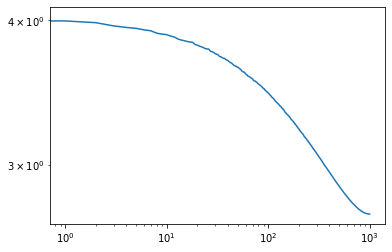

In [53]:
plt.loglog(np.exp(np.exp(evals)))

In [29]:
w,v = np.linalg.eig(mat)

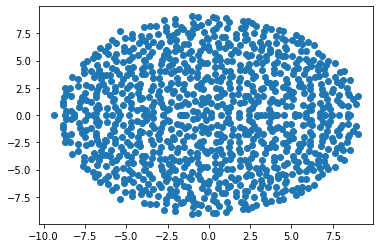

In [42]:
reals, imags = [i.real for i in w[1:]], [i.imag for i in w[1:]]
plt.scatter(reals, imags)

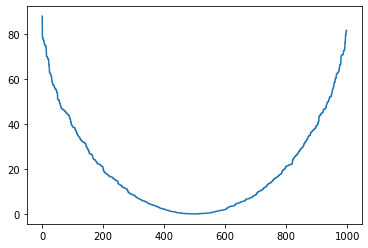

In [54]:
plt.plot(np.square(sorted(reals)))